# SODA: Bottleneck Diffusion Models for Representation Learning
## Introduction
SODA is a self-supervised diffusion model designed for representation learning. The model uses an encoder which produces a latent representation for a source view, then this latent representation is used to guide novel view generation by a diffusion model. The model is trained in a self-supervised manner using novel view synthesis objective. Abstractly, given a source view, the model is trained to generate novel views of the same object guided by additional information regarding the target view. 
## Goal of This Project
In the SODA paper authors experiment with a variety of tasks to show the capability of the model to learn high quality representations. Tasks including Linear-Probe Classification, Visual Synthesis, Disentanglement and Controllablity of the latent structure. In this project I chose the Visual Synthesis task and specifically the task Novel View Synthesis for 3D datasets.




In [ ]:
!pip install -r requirements.txt
!sudo apt-get install p7zip-full

## Database
For this experiment I used NMR ((Neural 3D Mesh Renderer)) dataset which contains 13 groups of objects and for each object there are 24 views taken by putting the camera at constant distant and elevation and with 24 evenly spaced Azimuth angles. There are roughly one million images (counting all the views for each object) in the dataset. The resolution of each image in the dataset is 64x64.
Here are the classes present in the NMR dataset:

In [1]:
import yaml
from pathlib import Path
from src.datasets import NMR
from visualization import plot_multiple_views

with open(Path('configs/NMR.yaml'), 'r') as file:
    cfg = yaml.full_load(file)
dataset = NMR(**cfg['dataset'])
test_set = dataset.get_test_set().get_target_dataset()
print(dataset.CLASS_IDS_MAP)

Dataset already downloaded!
Dataset already extracted!
{'02691156': 'Airplane', '02958343': 'Car', '04256520': 'Sofa'}


Example of the views of some objects:

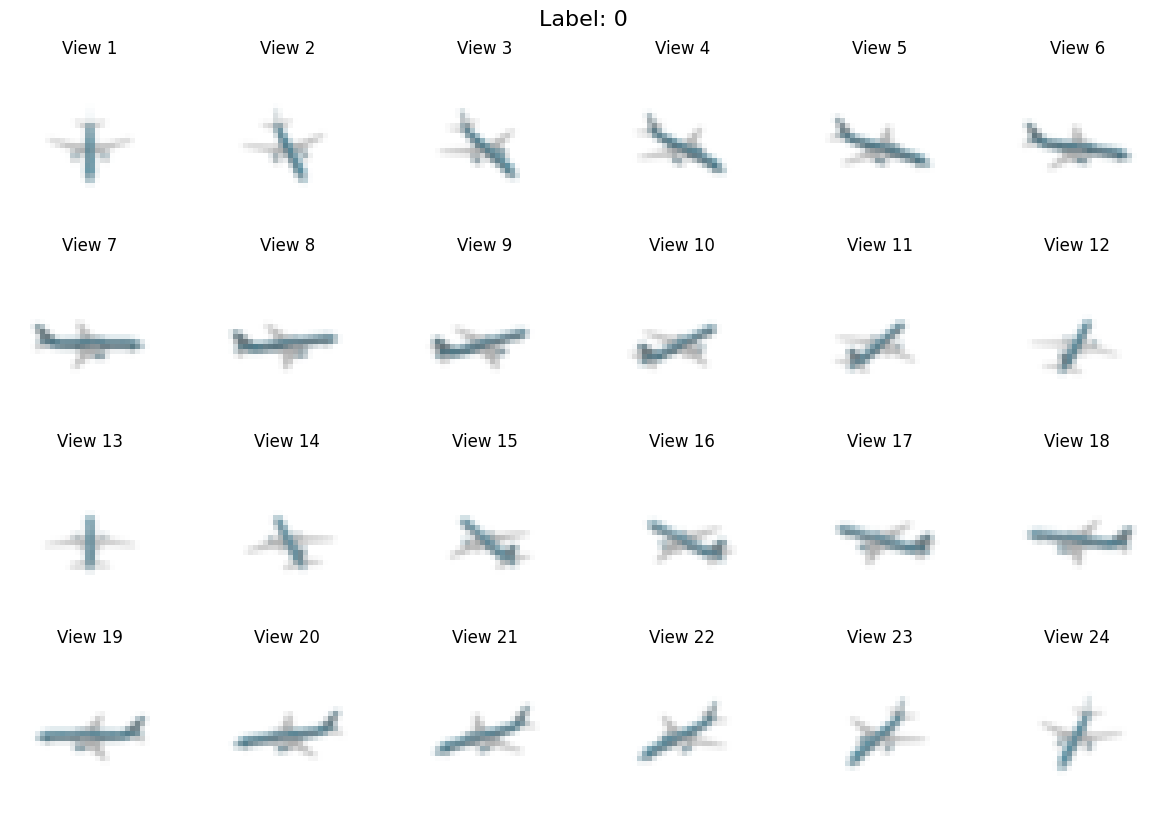

In [2]:
object_plane_views, _, label = test_set.get_all_views(3)
object_plane_views = (object_plane_views.permute(0, 2, 3, 1) + 1) / 2
plot_multiple_views(object_plane_views, label)

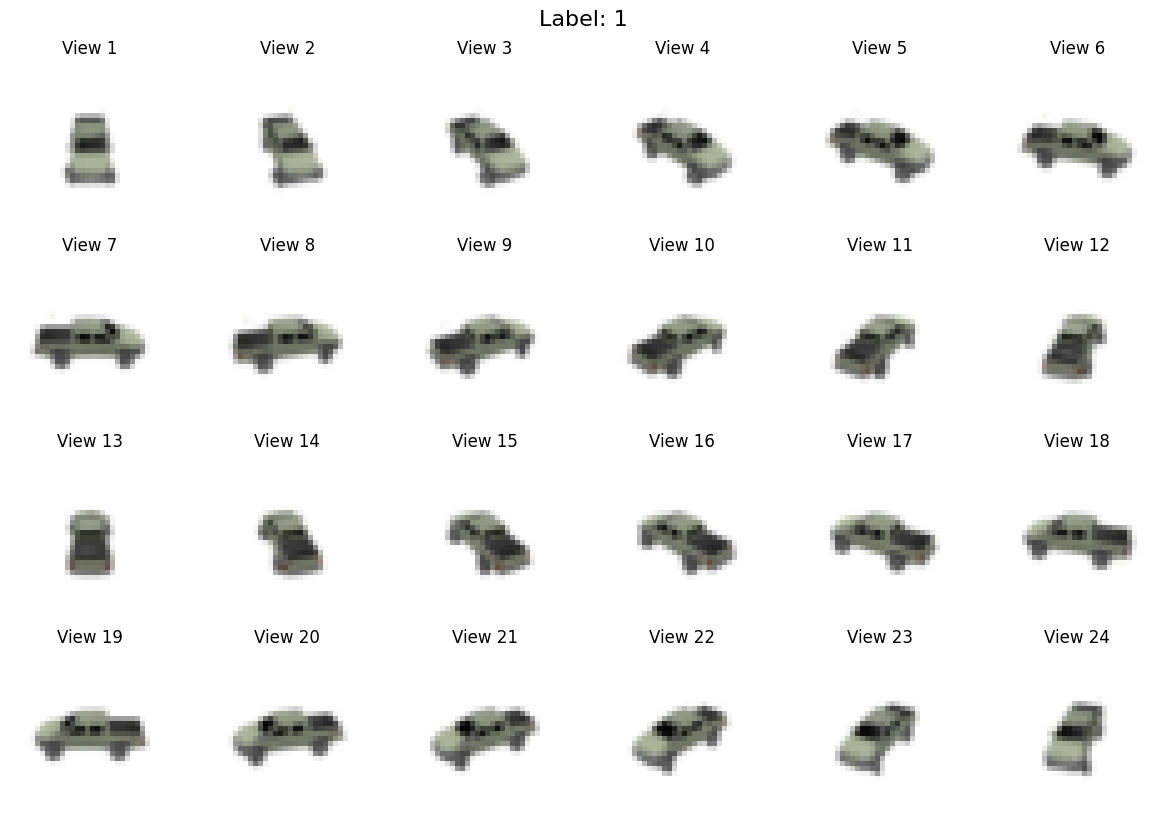

In [3]:
object_car_views, _, label = test_set.get_all_views(2000)
object_car_views = (object_car_views.permute(0, 2, 3, 1) + 1) / 2
plot_multiple_views(object_car_views, label)

In [4]:
from sample import generate_GIF
from IPython.display import display, HTML, Image as IPImage
sample_data_dir = Path('outputs/presentation_files')
sample_data_dir.mkdir(exist_ok=True)
nbs_plane_path = sample_data_dir/Path('nbs_plane.gif')
nbs_car_path = sample_data_dir/Path('nbs_car.gif')
generate_GIF(object_plane_views, nbs_plane_path)
generate_GIF(object_car_views, nbs_car_path)
gif_html = f'''
<div style="display: flex; justify-content: center; gap: 20px; margin-top: 20px;">
    <div>
        <img src="{nbs_plane_path}" style="width:300px; height:auto;" loop="infinite"/>
    </div>
    <div>
        <img src="{nbs_car_path}" style="width:300px; height:auto;" loop="infinite"/>
    </div>
</div>
'''
HTML(gif_html)

To make training feasible for my computational resources, I excluded 10 classes from the dataset and only three classes are used to train the model. These three classes are `Airplane`, `Car`, and `Sofa`. Hence, the number of objects remaining in the dataset after removing other classes are:

In [5]:
# airplane_id, car_id, sofa_id = '02691156', '02958343', '04256520'
import json
print(json.dumps(dataset.get_dataset_size_info(), indent=4))

{
    "train": {
        "02691156": 2831,
        "02958343": 5247,
        "04256520": 2221
    },
    "val": {
        "02691156": 405,
        "02958343": 749,
        "04256520": 317
    },
    "test": {
        "02691156": 809,
        "02958343": 1500,
        "04256520": 635
    }
}


Each split has two corresponding datasets, one source dataset and one target datset. Source dataset is used to provide input datat to the encoder model and target dataset is used to provide data for the diffusion model. Items in the dataset correspond to each object and all of its 24 views. There is a possibility to load different number of views for each object while drawing batches from the dataloader. Also the image transformations for the source (encoder input) and target (denoiser input) datasets differ.  

In [6]:
print(dataset.encoder_transformations)
print(dataset.denoizer_transformation)

Compose(
      Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.90754463, 0.90124703, 0.89597464], std=[0.21146126, 0.22668979, 0.24028395], inplace=False)
)
Compose(
      Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
      Lambda(<lambda>, types=['object'])
)


In addition to the 24 views corresponding to each object, NMR dataset provides camera matrix information for each view which is used to produce 2D ray-grids for each image where each ray is the concatenation of the origin vetor and direction vector:
$r [o,d]$
These ray-grids are later used to provide additional guidance signals for both encoder and diffusion model.
So in each batch we have one source batch and one target batch where each one contains the corresponding views, ray grids, and labels.

In [7]:
test_loader = dataset.get_test_dataloader()
source_batch, target_batch = next(iter(test_loader))
source_views, source_rays, source_labels = source_batch
target_views, target_rays, target_labels = target_batch
print(source_views.shape, source_rays.shape, source_labels.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32, 32, 32, 6]) torch.Size([32])


## Implementation Details
### Encoder
For the encoder $\mathcal{E}$ model the authors state that they have used a `ResNet50 V2` for NMR datset but I used the smaller version `ResNet18 V2` to reduce the training cost. In the original paper authors state that they resize images to 256x256 before feeding them to the encoder. In this project I used 64x64 and 32x32 images so I replaced the first conv layer of the ResNet which has a kernel size of 7, with a convolution layer with kernel size 3. Furthermore I removed the first max pooling layer in the network.

Before we feed images to the decoder, we use NeRF-style sinusoidal positional encoding to transform ray infromation from cartesian coordinates to frequency spectrum. The dimension of the encoded rays depends on the number of frequency bands. I used 30 bands (15 for position and 15 for directions).


In [8]:
import torch
from src.models.blocks import RayEncoder
pose_embedding = RayEncoder(pos_octaves=15, dir_octaves=15)
ray_pos, raydirs = torch.split(source_rays, (3, 3), dim=-1)
encoded_rays = pose_embedding(ray_pos, raydirs)
print(encoded_rays.shape)

torch.Size([32, 180, 32, 32])


After encoding ray-grids, we concatenate them to the linearly projected source images in the channel dimension and feed them to the encoder.
The encoder then produced a letent vector $z$ which is used to guide generation in the denoiser decoder.
$$
z = \mathcal{E}(\text{concat}[x',c])
$$

In [9]:
from src.models import SodaEncoder
encoder = SodaEncoder(**cfg['encoder'])
z = encoder(source_views, source_rays)
print(z.shape)

torch.Size([32, 256])


### Decoder (Denoising Diffusion Model)
The architecture used for the decoder $\mathcal{D}$ in SODA is a U-Net similar to the model used in DDPM paper with some modifications. In the original paper authors state that they used 128x128 images to train the decoder however in this project I experimented with lower resolution images (64x64 and 32x32). Similar to the encoder, we concatenate the ray-grids to the linearly projected noisy target images and feed them to the denoiser:
$$
\epsilon_{\theta} = \mathcal{D}(\text{concat}[x,c], z, t, m)
$$
where $m$ is the mask used to randomly mask $z$.
The latent vector $z$ guides the denoiser with Classifier Free Guidance and using Adaptive Group Normalization:
$$
\text{AdaGN}(h, z, t) = z_s (t_s\text{GroupNorm}(h) + t_b)z_b
$$
where $(t_s, t_b)$ and $(z_s, z_b)$ are linear projections of the time embedding and latent vector.
In the paper authors state that for 3D datasets and NVS task if we use cross attention for conditioning on $z$ it would slightly improve the preformance.

For time embeddings, the authors used a modified version of sinusoidal positional encoding where they scale the arguments of sin and cos by a factor of $2\pi s$ where $s$ is the scale hyperparameter and is set to be $1e-4$.

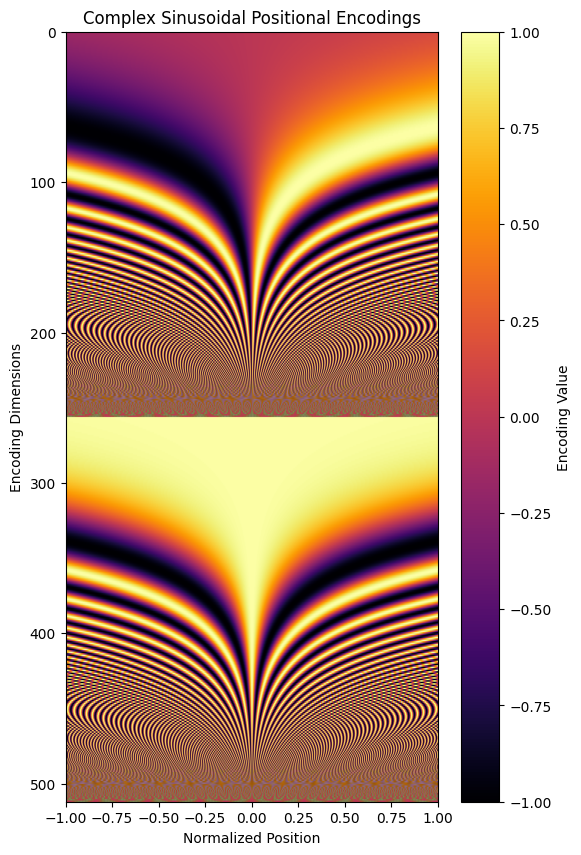

In [10]:

import numpy as np
from visualization import plot_sinusoidal_encoding
from src.models.blocks import ScaledSinusoidalPositionEmbedBlock
scaled_sin_enc = ScaledSinusoidalPositionEmbedBlock(dim=512)
positions = torch.linspace(-1, 1, steps=1000)
encodings = scaled_sin_enc(positions)
plot_sinusoidal_encoding(encodings.squeeze().detach().numpy().T)

Also for noise schedule used for perturbing input images to the denoiser, authors use a novel method called `Inverted Cosine Schedule` which prioritizes medium noise levels, and apparently this aids the task of representation learning.

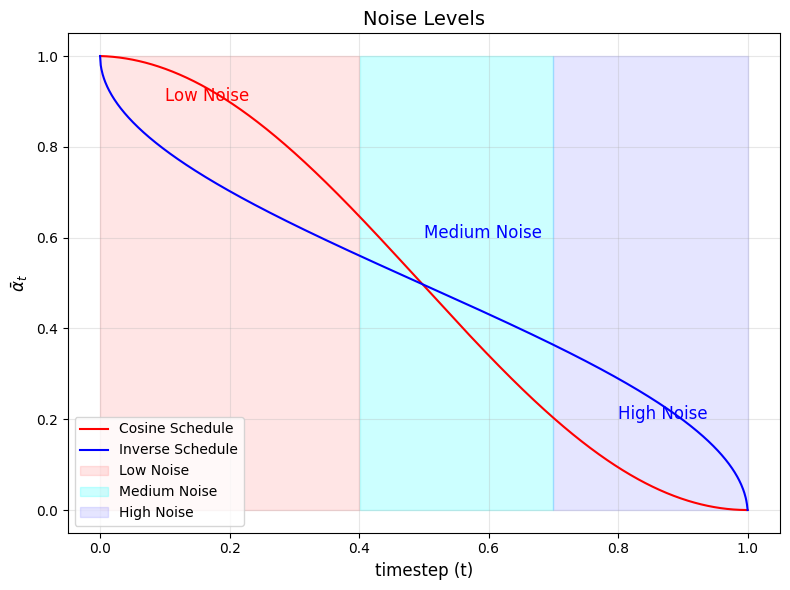

In [11]:
from src.models.noise_schedules import get_schedule
from visualization import plot_noise_schedules
T = 1000
cosine_sche = get_schedule('cosine', T)
inverted_cosine_sche = get_schedule('inverted', T)
plot_noise_schedules(cosine_sche, inverted_cosine_sche, T)

### Joint Model
The encoder $\mathcal{E}$ and decoder $\mathcal{D}$ are trained jointly, and at each training step:
1. One source view $x'$ and target view $x$ are sampled for each object in the batch alongside their corresponding ray-grids $c'$ and $c$ (encoded with NeRF encoding).
2. $$
    z = \mathcal{E}(\text{concat}[x',c'])
$$
3. A timestep is randomly sampled $t \sim \text{Uniform}[0, T]$ and is normalized to the range $[-1, 1]$ and encoded with sinusoidal encoding.
4. A random mask $m$ is sampled from a Bernoulli distribution with a prespecifed probability.
5. The target view $x'$ is purterbed using noise from time step $t$:
   $$
    \epsilon \sim \mathcal{N}(0, \boldsymbol{I})
   $$ 
   $$
    x_t = \sqrt{\bar{\alpha_t}} \, x_0 +  (1-\bar{\alpha_t}) \, \epsilon
   $$

6. Then we feed the noisy image and its ray-grid, latent vector, time embedding, and the mask to the decoder: 
   $$
    \epsilon_{\theta} = \mathcal{D}(\text{concat}[x,c], z, t, m)
   $$
7. The joint model is trained to minimize the MSE loss:
    $$
        \mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta \|_2^2 \right]
    $$

In [13]:
from src.models import UNet, SODA
denoiser = UNet(**cfg['denoiser'])
soda = SODA(
        encoder=encoder,
        decoder=denoiser,
        **cfg['SODA']
    )

## Training 
I trained the model with different hyperparameters on an RTX 4080 GPU. The training with three classes would take more than 20 hours for 32x32 images and more than 60 hours for 64x64 images.
### Simplifications
The generated samples and evaluation metrics (except the LinearProbe task) are far from the ones depicted in the paper and I think the reasons are the following:
1. The authors trained the models with higher resolutions which approximately takes 32 to 64 times computational time from what I experimented with.
2. I used a simpler encoder architecture compared to what was mentioned in the paper.
3. I kept the U-Net as simple as possible to reduce the computational cost and this could cause lower quality samples.
4. I did not implement the cross attention layer for CFG using the latent vector and kept the layer modulation approach.
5. Possibly, the number of training steps I used in my experiments are not enough (800-1000 epochs)

### Process
The training can be done by running the `train.py` script as follows:

In [ ]:
!python train.py
# To resume from last saved checkpoint
!python train.py --resume 

After the training is finished, the weights corresponding to EMA model is saved in the `weights/` directory in the root of the project.

### Training Stats
Here are the graphs showing the evolution of training loss, validation loss, linear probing accuracy, and some other metrics during training:

In [20]:
# Load tensorboard logs
%load_ext tensorboard
%tensorboard --logdir 'media/Mosix11-2025-01-08 13:48:39.937665'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6011 (pid 664038), started 0:00:08 ago. (Use '!kill 664038' to kill it.)

## Sampling
The sampling procedure is done using DDIM sampling procedure (deterministic sampling) and given a random source view of an object the model will asked to generate all 24 views corresponding to that object based on the source view and ray-grid information of the target views.
We can sample from the model using the test dataset by the following command:

In [ ]:
!python sample.py --objidx 3

Here I we can see some examples of Novel View Synthesis using one source view:

In [27]:
from IPython.display import display, HTML

def generate_html(id):
    html_template = f"""
    <div style="display: flex; flex-direction: column; align-items: center; gap: 20px;">
        <!-- First Line: Three Images -->
        <div style="display: flex; justify-content: space-between; width: 100%; max-width: 1000px;">
            <img src="media/samples/{id}-real.png" style="width: 40%; height: auto;">
            <img src="media/samples/{id}-source.png" style="width: 10%; height: auto; object-fit: contain;">
            <img src="media/samples/{id}-gen.png" style="width: 40%; height: auto;">
        </div>

        <!-- Second Line: Two GIFs -->
        <div style="display: flex; justify-content: center; gap: 200px;">
            <img src="media/samples/{id}-real.gif" style="width: 200px; height: auto;">
            <img src="media/samples/{id}-gen.gif" style="width: 200px; height: auto;">
        </div>
    </div>
    """
    return html_template

HTML(generate_html(1000))


In [28]:
HTML(generate_html(3))

In [29]:
HTML(generate_html(3))